In [1]:
import os
import pandas as pd
import numpy as np

csvs = [ f for f in os.listdir('data') if f.endswith('.csv')]
data = {}
for c in csvs:
    data[ c[:c.index('-')] ] = pd.read_csv(os.path.join('data', c))

In [2]:
shared_columns = {}
for date, d in data.items():
    print('{}\n'.format(date))
    print('\tRows: {0}\tColumns: {1}\n'.format(*d.shape))
    col_set = set(d.columns)
    if not shared_columns:
        shared_columns = col_set
    else:
        if col_set > shared_columns:
            print("\tExtra columns: {}\n".format(col_set - shared_columns))
        elif col_set < shared_columns:
            print("\tMissing columns: {}\n".format(shared_columns - col_set))
print('Shared columns:\n')
for c in sorted(list(shared_columns)):
    print('\t{}'.format(c))

201804

	Rows: 131169	Columns: 16

201809

	Rows: 186217	Columns: 16

201803

	Rows: 111382	Columns: 16

201802

	Rows: 106718	Columns: 16

201801

	Rows: 94802	Columns: 16

201806

	Rows: 195968	Columns: 16

201901

	Rows: 192082	Columns: 16

201805

	Rows: 179125	Columns: 16

201904

	Rows: 239111	Columns: 16

201902

	Rows: 183412	Columns: 16

201812

	Rows: 131363	Columns: 16

201810

	Rows: 201458	Columns: 16

2017

	Rows: 519700	Columns: 15

	Missing columns: {'bike_share_for_all_trip'}

201808

	Rows: 192162	Columns: 16

201807

	Rows: 199222	Columns: 16

201811

	Rows: 134135	Columns: 16

201903

	Rows: 256299	Columns: 16

Shared columns:

	bike_id
	bike_share_for_all_trip
	duration_sec
	end_station_id
	end_station_latitude
	end_station_longitude
	end_station_name
	end_time
	member_birth_year
	member_gender
	start_station_id
	start_station_latitude
	start_station_longitude
	start_station_name
	start_time
	user_type


In [3]:
df_merged = data['2017'].copy()
df_merged['bike_share_for_all_trip'] = np.nan
for d in data:
    if d == '2017':
        continue
    df_merged = pd.concat([df_merged, data[d] ], ignore_index=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254325 entries, 0 to 3254324
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 397.3+ MB


In [4]:
df = df_merged.copy()

In [5]:
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)
df.start_station_id = df.start_station_id.astype('Int64').astype(str)
df.end_station_id = df.end_station_id.astype('Int64').astype(str)
df.bike_id = df.bike_id.astype('Int64').astype(str)
df.member_birth_year= df.member_birth_year.astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254325 entries, 0 to 3254324
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          Int64
member_gender              object
bike_share_for_all_trip    object
dtypes: Int64(1), datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 400.4+ MB


In [6]:
df.head(20)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987,Male,NaN
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965,Female,NaN
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997,Female,NaN
5,9226,2017-12-31 22:51:00.918,2018-01-01 01:24:47.166,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,1487,Customer,NaN,NaN,NaN
6,4507,2017-12-31 23:49:28.422,2018-01-01 01:04:35.619,259,Addison St at Fourth St,37.866249,-122.299371,259,Addison St at Fourth St,37.866249,-122.299371,3539,Customer,1991,Female,NaN
7,4334,2017-12-31 23:46:37.196,2018-01-01 00:58:51.211,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,1503,Customer,NaN,NaN,NaN
8,4150,2017-12-31 23:37:07.548,2018-01-01 00:46:18.308,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,3125,Customer,NaN,NaN,NaN
9,4238,2017-12-31 23:35:38.145,2018-01-01 00:46:17.053,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,2543,Customer,NaN,NaN,NaN


In [62]:
#https://gist.github.com/rochacbruno/2883505

import math

def distance(start_lat, start_lon, end_lat, end_lon):
    radius = 6371 * 1000 # meters

    dlat = math.radians(end_lat-start_lat)
    dlon = math.radians(end_lon-start_lon)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(start_lat)) \
        * math.cos(math.radians(end_lat)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [63]:
df['trip_distance'] = df.apply(lambda x: distance(
    x.start_station_latitude, x.start_station_longitude,
    x.end_station_latitude, x.end_station_longitude), axis=1)

In [65]:
df[ df.start_time.dt.year < 2018 ]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,distance
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987,Male,NaN,942.931149
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965,Female,NaN,3069.727100
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN,0.000000
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN,1046.622092
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997,Female,NaN,636.339384
5,9226,2017-12-31 22:51:00.918,2018-01-01 01:24:47.166,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,30,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,1487,Customer,NaN,NaN,NaN,0.000000
6,4507,2017-12-31 23:49:28.422,2018-01-01 01:04:35.619,259,Addison St at Fourth St,37.866249,-122.299371,259,Addison St at Fourth St,37.866249,-122.299371,3539,Customer,1991,Female,NaN,0.000000
7,4334,2017-12-31 23:46:37.196,2018-01-01 00:58:51.211,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,1503,Customer,NaN,NaN,NaN,0.000000
8,4150,2017-12-31 23:37:07.548,2018-01-01 00:46:18.308,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,3125,Customer,NaN,NaN,NaN,0.000000
9,4238,2017-12-31 23:35:38.145,2018-01-01 00:46:17.053,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,2543,Customer,NaN,NaN,NaN,0.000000


In [66]:
df[ df.start_time.dt.year < 2018 ].start_time.dt.month.value_counts()

10    108937
9      98558
11     95612
12     86539
8      83292
7      44073
6       2689
Name: start_time, dtype: int64

In [67]:
df['start_month'] = df.start_time.dt.month
df['start_year'] = df.start_time.dt.year
df['start_day'] = df.start_time.dt.day
df['duration_min'] = df.duration_sec / 60
df['member_age'] = df.apply(lambda x: x.start_year - x.member_birth_year, axis=1)

In [69]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,distance,start_month,start_year,start_day,duration_min,age
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,...,Customer,1987,Male,NaN,942.931149,12,2017,31,1335.166667,30.0
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,...,Customer,1965,Female,NaN,3069.727100,12,2017,31,1313.333333,52.0
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,...,Customer,NaN,NaN,NaN,0.000000,12,2017,31,762.800000,NaN
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,...,Customer,NaN,NaN,NaN,1046.622092,12,2017,31,1036.200000,NaN
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,...,Subscriber,1997,Female,NaN,636.339384,12,2017,31,726.716667,20.0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3254325 entries, 0 to 3254324
Data columns (total 22 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          Int64
member_gender              object
bike_share_for_all_trip    object
distance                   float64
start_month                int64
start_year                 int64
start_day                  int64
duration_min               float64
age                        float64
dtypes: Int64(1), datetime64[ns](2), float64(7), int64(4), object(8)
memory usage: 549.3+ MB


In [7]:
del data
del df_merged

In [11]:
import matplotlib.pyplot as plt
import seaborn as sb

bc = sb.color_palette()[0]

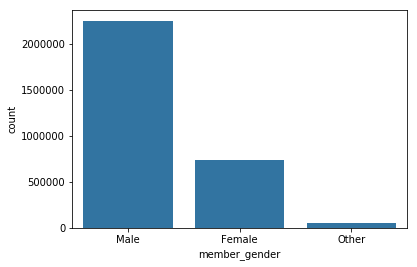

In [13]:
sb.countplot(data = df, x = 'member_gender', color = bc);

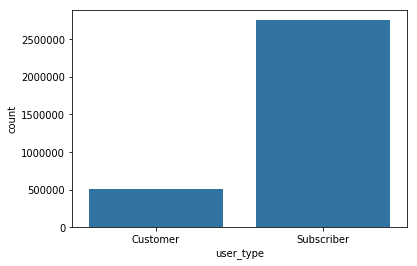

In [14]:
sb.countplot(data = df, x = 'user_type', color = bc);

In [18]:
df.start_station_name.value_counts()

San Francisco Ferry Building (Harry Bridges Plaza)                 67991
San Francisco Caltrain Station 2  (Townsend St at 4th St)          66643
Market St at 10th St                                               64551
San Francisco Caltrain (Townsend St at 4th St)                     59937
Berry St at 4th St                                                 58722
The Embarcadero at Sansome St                                      57546
Montgomery St BART Station (Market St at 2nd St)                   56920
Powell St BART Station (Market St at 4th St)                       54947
Steuart St at Market St                                            49017
Howard St at Beale St                                              47053
Powell St BART Station (Market St at 5th St)                       44717
Embarcadero BART Station (Beale St at Market St)                   37898
3rd St at Townsend St                                              36266
Townsend St at 7th St                              

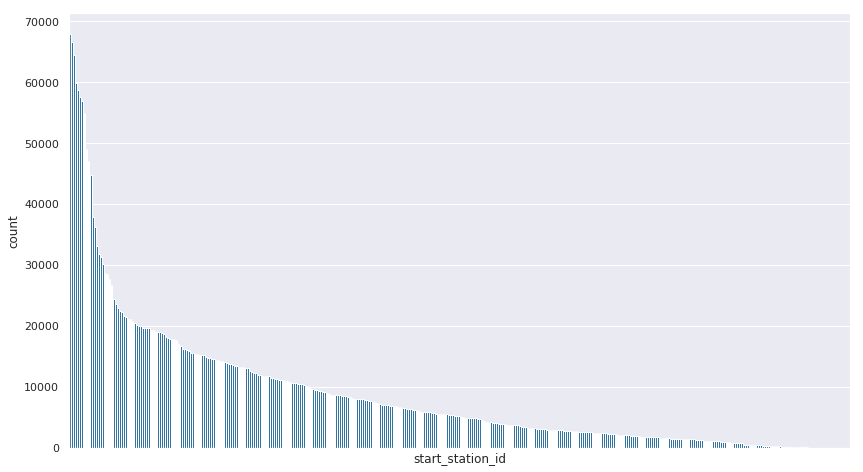

In [54]:
sb.set(rc={'figure.figsize':(14,8)})
start_ord = df['start_station_id'].value_counts().index
ax = sb.countplot(data = df, x = 'start_station_id', color = bc, order = start_ord)
ax.set_xticks([]);

In [55]:
df.end_station_name.value_counts()

San Francisco Caltrain Station 2  (Townsend St at 4th St)          88013
San Francisco Ferry Building (Harry Bridges Plaza)                 78077
San Francisco Caltrain (Townsend St at 4th St)                     72855
The Embarcadero at Sansome St                                      68159
Montgomery St BART Station (Market St at 2nd St)                   66065
Market St at 10th St                                               63523
Powell St BART Station (Market St at 4th St)                       57743
Berry St at 4th St                                                 56857
Steuart St at Market St                                            49351
Powell St BART Station (Market St at 5th St)                       46403
Howard St at Beale St                                              41272
3rd St at Townsend St                                              34930
Townsend St at 7th St                                              34691
Civic Center/UN Plaza BART Station (Market St at Mc

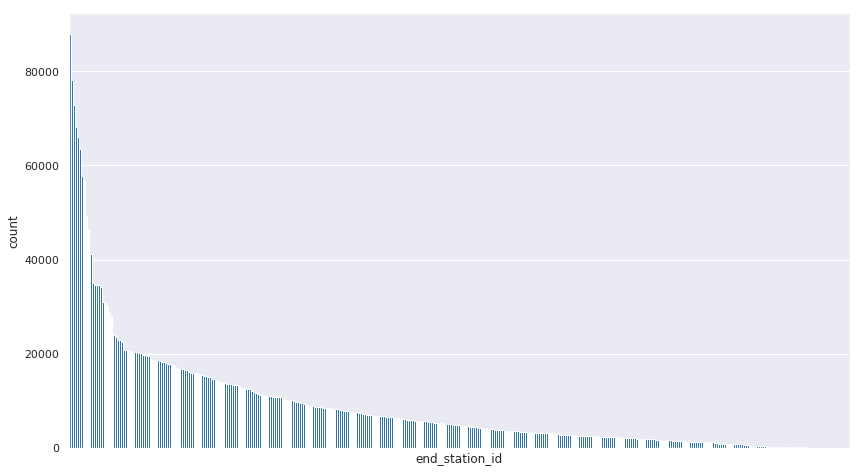

In [56]:
start_ord = df['end_station_id'].value_counts().index
ax = sb.countplot(data = df, x = 'end_station_id', color = bc, order = start_ord)
ax.set_xticks([]);

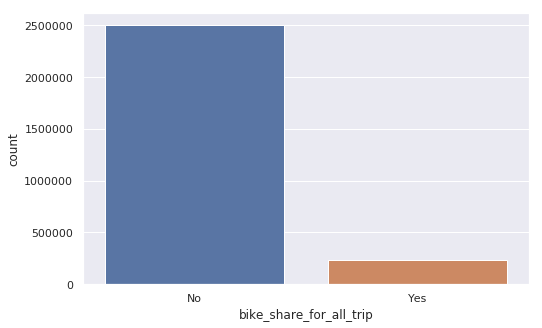

In [41]:
sb.set(rc={'figure.figsize':(8,5)})
sb.countplot(data=df, x='bike_share_for_all_trip');

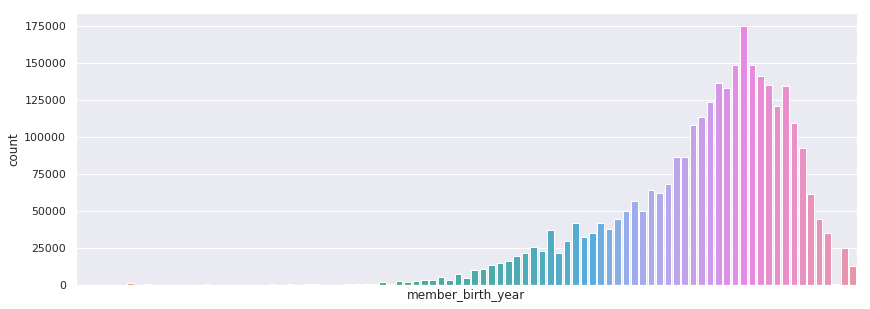

In [53]:
ax = sb.countplot(data=df, x='member_birth_year')
ax.set_xticks([]);

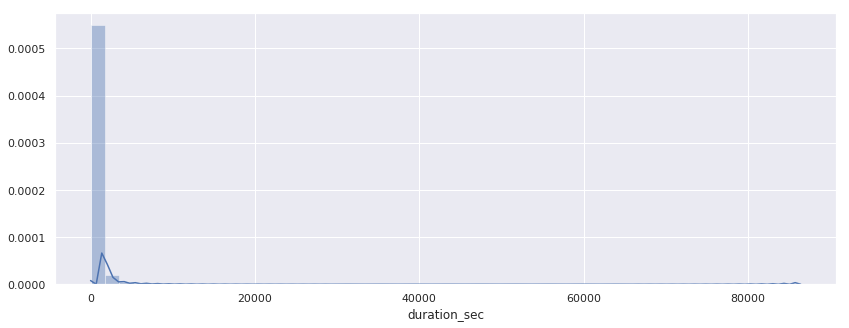

In [52]:
sb.set(rc={'figure.figsize':(14,5)})
sb.distplot(df['duration_sec']);

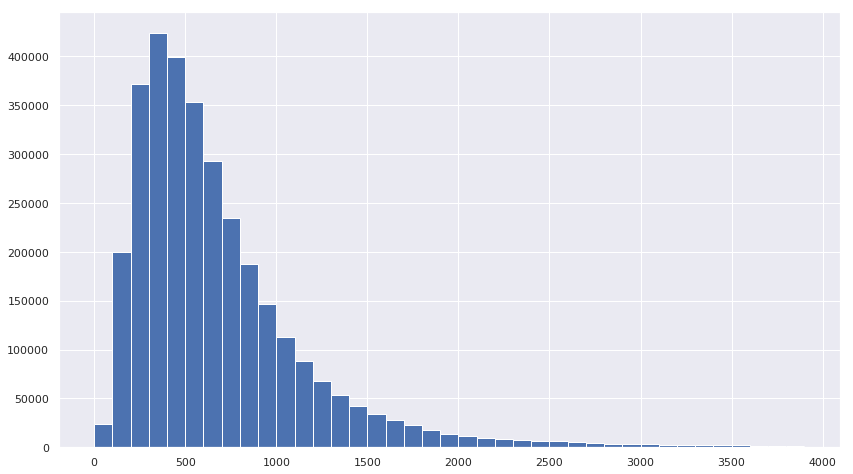

In [59]:
bins = np.arange(0, 4000, 100)
plt.hist(data=df, x='duration_sec', bins=bins);